# Rapport de projet de session - IFT 712
### Objectif du projet : tester six méthodes de classification sur une base de données Kaggle.

Nous avons choisi la base de données "[Heart Failure Prediction Dataset][0]" puisqu'elle permet de faire de la classification sur un jeu de données réel et avec des applications concrètes.
Les méthodes de classification que nous allons tester sont les suivantes :
* Réseau de neurones
* K plus proches voisins
* Régression logistique
* Modèle Gaussien naïf
* SVM
* Forêt aléatoire

Pour cela, nous utiliserons la bibliothèque scikit-learn pour implémenter les algotihmes ainsi que pandas  pour traiter les données

Nous utiliserons également [Trello][1] ainsi que discord afin d'organiser le projet à haut niveau
Le code est versionné sur [Github][1] en suivant les conventions suivantes :
* conventionals [commits][3]
* merge requests sur master
* une branche par feature

Le code et les commentaires sont rédigés en francais et suivant la convention [pep8][4] au possible. Nous utiliserons la fonctionnalité "code with me" de pycharm permettant à plussieurs membres du groupe de coder sur le même projet en même temps

[0]: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
[1]: https://trello.com/b/U21MHLaj/projet-ift712-deadline-11-12-23
[2]: https://github.com/MorganChabaudENSSAT/projet_ift712
[3]: https://www.conventionalcommits.org/en/v1.0.0/
[4]: https://peps.python.org/pep-0008/

In [1]:
'''
 Imporation des bibliothèques python générales
'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import warnings

'''
 Imporation des bibliothèques spécifiques au devoir
'''


'''
    Suppression des Future Warnings 
'''
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings( "ignore")

In [2]:
# Importation des données
df = pd.read_csv('heart.csv') # Dataframe contenant les données
features_names = df.columns
features_nbr = features_names.shape[0]
print(f"nombre de features dans le dataset : {features_nbr}")
# Visualisation des données pour mieux les comprendre
print(df.head())
print(df.dtypes)

nombre de features dans le dataset : 12
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG 

A partir de cette visualisation primaire des données, on  remarque que certaines features sont catégoriques ce qui empêche de les utiliser telles quelles dans les algorithmes de classification.
=> On va donc devoir traiter ces valeurs en les encodant.

In [3]:
le = LabelEncoder()

data = df.copy(deep = True)

data['Sex'] = le.fit_transform(data['Sex'])
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])
data['RestingECG'] = le.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])

# Les données sont mainteant toutes numériques et utilisables par les algorithmes de classification que nous mettrons en place
print(data)

#On récupère dasn des listes les données qui était catégoriques
categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
numerical_features = [x for x in features_names if x not in categorical_features]
numerical_features = numerical_features[:-1]

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

A présent, on explore les données à l'aide de visualisations afin de mieux comprendre leur nature et détecter les features les plus caractéristiques ainsi que la nature des distributions des données afin, au besoin, de formuler des hypothèses nous permettant de mettre en oeuvre différents modèles.
On commence par visualiser la distribution de chaque feature.

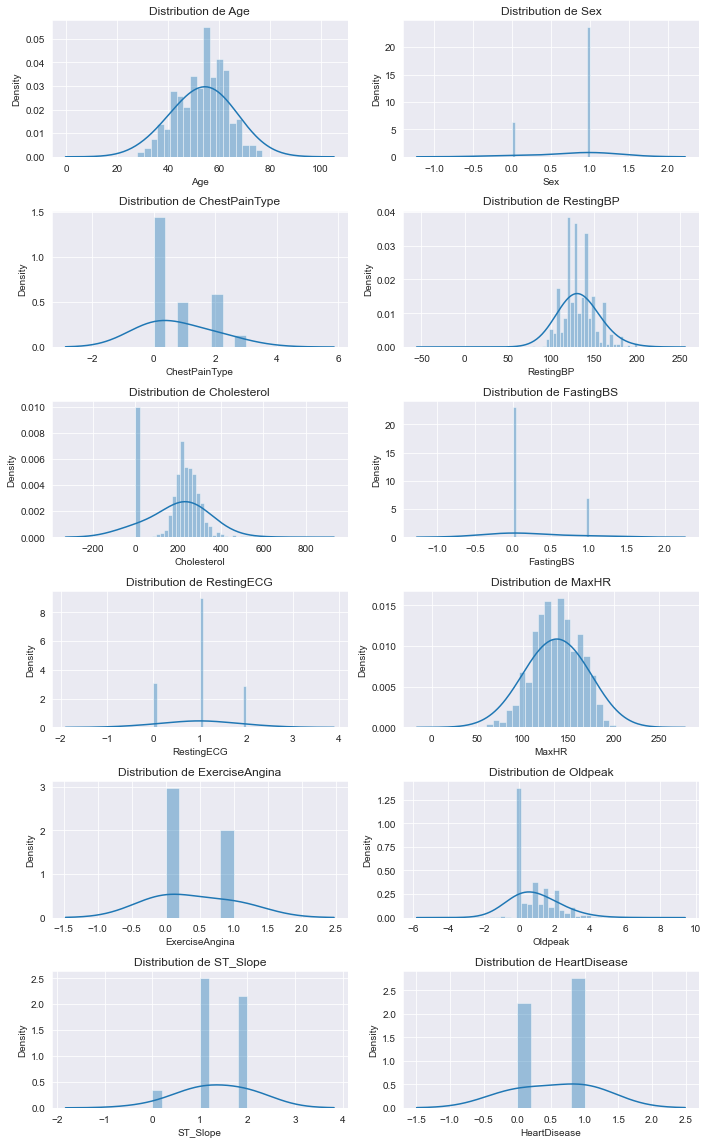

In [4]:
fig = plt.figure(figsize=(10,16))
for i in range(features_nbr):
    plt.subplot(int(features_nbr/2), 2, i+1)
    fig.tight_layout()
    cur_feature =features_names[i]
    sns.distplot(data[cur_feature], kde_kws={'bw' : 1})
    plt.title("Distribution de "+cur_feature)

La plupart des données suivent une distribution normale. On n'observe pas d'outliers dans les données ce qui implique qu'on pourra, au besoin, utiliser les techniques de préprocessing de normalisation et de standardisation sur les données sans mettre en exergue de valeurs abérantes.

# 2 - K plus proches voisins

Dans cette partie, on classifie les données à l'aide du classifieur par K plus proches voisins.
Nous évaluerons la valeur de l'hyperparamètre K à l'aide d'une recherche de type 'grid-search' utilisant une 'stratified-cross-validation'

On commence par initialiser un classifieur dit 'naïf' avec l'hyperparamètre K=5 afin d'avoir une base sur laquelle travailler.

In [5]:
from k_plus_proches_voisins import K_PP_voisins

# Instantiation du modèle avec K =5
knn_model_naif =  K_PP_voisins(data, features_names, features_nbr)

On entraîne le modèle sur les données non traitées

accuracy du modèle : 0.7010869565217391


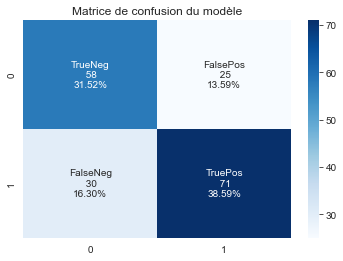

In [6]:
# Génération des ensembles d'entrainement et de test
X_train, X_test, y_train, y_test = knn_model_naif.split_data(data)
# Entraînement du modèle sur les données X_train et y_train
knn_model_naif.train(X_train, y_train)
# Evaluation du modèle
knn_model_naif.evaluate_model(X_test,y_test)

Le modèle a une accuracy de 70%, ce qui semble assez faible. Cela est bien sûr causé par l'utilisation du modèle sur des données non transformées.

On normalise puis standardise les données numériques afin de comparer le gain d'accuracy entre les deux modèles.

In [7]:
# Normalisation des données numériques
scaled_data_knn = knn_model_naif.scale_data(numerical_features,numerical_features)

On Visualise les données afin de nous assurer que les opérations ont été réalisées avec succès

In [8]:
print(data)
print(scaled_data_knn)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

On peut alors entraîner le modèle de classification par K plus proches voisins sur les données transformées

In [9]:
# Instantiation du modèle avec K =5
knn_model_naif_2 =  K_PP_voisins(data, features_names, features_nbr)
# Génération des ensembles d'entrainement et de test a partir des données transformées
X_train, X_test, y_train, y_test = knn_model_naif_2.split_data(scaled_data_knn)
# Entraînement du modèle sur les données X_train et y_train
knn_model_naif_2.train(X_train, y_train)

On évalue la capacité du modèle à apprendre les données d'entraînement à l'aide de 'stratified-cross-validation'. Les données sur lesquelles est entrainé le modèle sont séparées en un ensemble d'entraînement et de validation permettant d'évaluer la capacité à généraliser du modèle. On évalue le score sur chaque fold puis on en prend la moyenne afin d'obtenir la meilleure évaluation de l'accuracy possible

In [10]:
knn_model_naif_2.K_fold(X_train,y_train)

Le score de cross-validation du modèle est:  0.8469394051585831


On évalue à présent le modèle sur les données de test.

accuracy du modèle : 0.8206521739130435


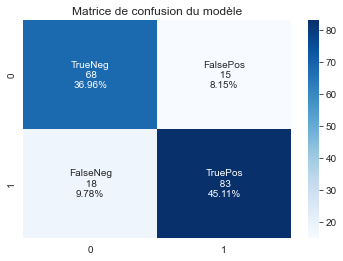

In [11]:
# Evaluation du modèle sur les données de test
knn_model_naif_2.evaluate_model(X_test, y_test)

Le modèle arrive à prédire correctement l'existence ou l'absence de maladie cardiaque dans environ 82% des cas sur les données de tests.
On constate une forte augmentation de l'accuracy du modèle par rapport au premier grâce au pré-traitement effectué sur les données.

#### Amélioration du modèle : recherche des hyperparamètres

L'analyse de base du classifieur étant établie, on procède maintenant à une recherche d'hyperparamètres. D'après la documentation de [sklearn][1] les hyperparamètres du modèles sont les suivants :
- n_neighbors : le nombre de voisins nécesaires pour la classification du point courant
- weights : La métrique utilisée pour prédire l'appartenance d'un point à une classe ou à une autre
- algorithm : algorithme utilisé pour le calcul
- leaf_size : nombre de points à partir duquel l'algorithme choisi les voisins en force brute
- p : puissance dans la distance de Minkowski indiquant la nature de la mesure
- metric : la métrique utilisée

On conserve la métrique de base (Minkowski) car le choix de la valeur de p permet de choisir la métrique indirectement.
Le jeu de données étant inférieur à 1000 points, on peut utiliser l'approche par force brute directement car le temps de calcul devrait rester raisonnable. Ainsi, on fixe leaf_size à 1.
L'algorithme utilisé pour le calcul des plus proches voisins est laissé à 'auto'.

Il nous reste donc à calculer les valeurs d'hyperparmètres suivants:
- n_neighbors
- weights
- p

On utilise une recherche d'hyperparamètres de type grid-search. Pour cela, on instancie un dictionnaire contenant les couples (noms du paramètres : valeurs prises par ce paramètre)

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [12]:
n_neighbors_values = np.linspace(1,20,20).astype(int) # valeurs prises par l'hyperparamètre n_neighbors
weights_values = ['uniform', 'distance']    # valeurs prises par l'hyperparamètre weights
p_values = np.linspace(1,10,10).astype(int) # valeurs prises par l'hyperparamètre p
h_parameters_to_tune ={
    'n_neighbors' : n_neighbors_values,
    'weights' : weights_values,
    'p' : p_values
}
other_parameters=['leaf-size=1','metric=minkowski']

In [13]:
knn_post_grid_search_estimator = knn_model_naif.hyper_parameters_search(X_train, y_train, h_parameters_to_tune, other_parameters)

0.8706178361755661  pour les hyperparamètres suivants :  {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


On constate une amélioration du score de cross-validation d'environ 2.5%

On intancie maintenant un nouveau classifieur avec les hyperparamètres que nous venons de trouver puis nous l'évaluons sur les données de test 

accuracy du modèle : 0.8641304347826086


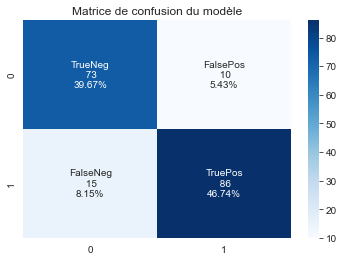

In [14]:
# instanciation du classifieur unitilisant les hyperparamètres trouvés
knn_2=K_PP_voisins(data, features_names, features_nbr,knn_post_grid_search_estimator)
# Evaluation
knn_2.evaluate_model(X_test, y_test)

L'accuracy du modèle s'est améliorée de presque 5% grâce au choix d'hyperparamètres que nous avons fait.

Afin d'améliorer davantage le modèle, on étudie les interactions entre le modèle et les données

#### Amélioration du modèle : nombre de données

A présent, on étudie le nombre de données nécessaire dans l'ensemble d'entraînement afin de favoriser l'apprentissage du modèle. Pour cela, on va évaluer la performance du modèle sur plusieurs ensembles d'entraînement dont les tailles sont différentes et afficher les résultats obtenus sous la forme de graphiques.
Afin de valider la capacité à généraliser du modèle, nous visualiserons également le score obtenu sur l'ensemble des données de validation.

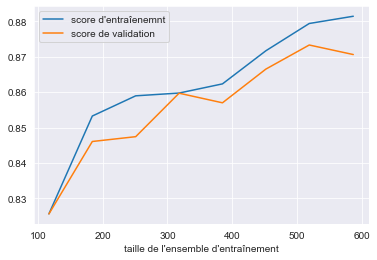

In [15]:
train_size = np.linspace(0.2,1,8)
knn_2.data_needed_for_max_score(X_train, y_train, train_size)

Ce graphique indique que la valeur d'accuracy représentée par les courbes d'apprentissage et de validation semble augmenter avec le nombre de données ce qui indique que le modèle n'est pas au bout de son apprentissage. Ainsi, si nous disposions de plus de données, nous pourrions rendre le modèle encore plus performant.

#### Conclusion sur le modèle des K plus proches voisins

Le modèle des K plus proches voisins a permis d'obtenir une accuracy de plus de **86%** sur l'ensemble de test aevc les hyperparamètres suivants : **{'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}** ce qui constitue un gain d'environ 16% par rapport au modèle naïf.
Nous avons observé que **le modèle pourrait gagner en accuracy en bénéficiant de plus de données lors de l'entraînement**.

Références: 
0 : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea